In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

### Bibliotecas

In [17]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

## Abertura do dados
---
Link: [Ministério da Economia](https://balanca.economia.gov.br/balanca/bd/comexstat-bd/ncm/IMP_COMPLETA.zip)

In [2]:
# df_bruto = pd.read_csv("/content/drive/Shareddrives/TCC Daniel dados/IMP_COMPLETA.csv",sep=';')
df_bruto = pd.read_csv('../datasets/IMP_COMPLETA.csv',sep=';')
df_bruto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36389808 entries, 0 to 36389807
Data columns (total 13 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   CO_ANO      int64 
 1   CO_MES      int64 
 2   CO_NCM      int64 
 3   CO_UNID     int64 
 4   CO_PAIS     int64 
 5   SG_UF_NCM   object
 6   CO_VIA      int64 
 7   CO_URF      int64 
 8   QT_ESTAT    int64 
 9   KG_LIQUIDO  int64 
 10  VL_FOB      int64 
 11  VL_FRETE    int64 
 12  VL_SEGURO   int64 
dtypes: int64(12), object(1)
memory usage: 3.5+ GB


## Tabelas auxiliares
---
Link: [Tabela Códigos](https://balanca.economia.gov.br/balanca/bd/tabelas/TABELAS_AUXILIARES.xlsx)

Indice Excel usado
* 16 (CO_NCM)
* 10 (CO_PAIS)
* 14 (CO_VIA)
* 15 (CO_URF)
* 12 (SG_UF)

In [3]:
#url = "https://github.com/Migliorin/Comex_Data_Analysis/blob/main/datasets/TABELAS_AUXILIARES.xlsx?raw=true"
# xl_file = pd.ExcelFile(url)

xl_file = pd.ExcelFile('../datasets/TABELAS_AUXILIARES.xlsx')
df_pais = xl_file.parse('10')
df_ncm = xl_file.parse('16')
df_via = xl_file.parse('14')
df_urf = xl_file.parse('15')
df_uf = xl_file.parse('12')

## Substituição código
---
Para melhor análise e entedimento, será usado a tabela de códigos para substituir os códigos dentro da base bruta. Como as colunas de alguns códigos serão traduzidas, então serão retirados as seguintes colunas:

* CO_NCM
* CO_PAIS
* CO_VIA
* CO_URF
* SG_UF_NCM

**Variável final**: df

In [4]:
df = df_bruto.merge(df_ncm[['CO_NCM','NO_CUCI_GRUPO']],on='CO_NCM').copy()
df = df.merge(df_pais[['CO_PAIS','NO_PAIS']],on='CO_PAIS')
df = df.merge(df_urf[['CO_URF','NO_URF']],on='CO_URF')
df = df.merge(df_via[['CO_VIA','NO_VIA']],on='CO_VIA')

df.rename({'SG_UF_NCM':'SG_UF'},axis=1,inplace=True)

df = df.merge(df_uf[['SG_UF','NO_REGIAO']],on='SG_UF')

In [5]:
df.drop(['CO_NCM','CO_PAIS','CO_URF','CO_VIA'],axis=1,inplace=True)

## Existência de dados nulos

In [6]:
df.isnull().sum()

CO_ANO           0
CO_MES           0
CO_UNID          0
SG_UF            0
QT_ESTAT         0
KG_LIQUIDO       0
VL_FOB           0
VL_FRETE         0
VL_SEGURO        0
NO_CUCI_GRUPO    0
NO_PAIS          0
NO_URF           0
NO_VIA           0
NO_REGIAO        0
dtype: int64

## Visualização do dataset

In [7]:
df.head()

,CO_ANO,CO_MES,CO_UNID,SG_UF,QT_ESTAT,KG_LIQUIDO,VL_FOB,VL_FRETE,VL_SEGURO,NO_CUCI_GRUPO,NO_PAIS,NO_URF,NO_VIA,NO_REGIAO
0,1997,9,10,SP,200,200,4888,180,24,Compostos de função nitrogênio,Bélgica,0817800 - PORTO DE SANTOS,MARITIMA,REGIAO SUDESTE
1,1999,11,10,SP,720,720,11304,75,0,Compostos de função nitrogênio,Bélgica,0817800 - PORTO DE SANTOS,MARITIMA,REGIAO SUDESTE
2,1999,5,10,SP,720,720,9948,138,0,Compostos de função nitrogênio,Bélgica,0817800 - PORTO DE SANTOS,MARITIMA,REGIAO SUDESTE
3,2000,11,10,SP,6000,6000,46260,2213,0,Compostos de função nitrogênio,Bélgica,0817800 - PORTO DE SANTOS,MARITIMA,REGIAO SUDESTE
4,2000,5,10,SP,5720,5720,51510,509,0,Compostos de função nitrogênio,Bélgica,0817800 - PORTO DE SANTOS,MARITIMA,REGIAO SUDESTE


## Visualização dos dados

## Países e Origens
---
Nesse gráfico é mostrado o número de importações feitas para o Brasil listando os mais 15 países de origem. De 1997 a 2022, os 5 países que mais exportaram para o Brasil foram:

1. Estados Unidos
2. China
3. Alemanha
4. Italia
5. Japão


O próximo gráfico mostra o destino dos produtos predominando a região Sudeste, enquanto a região Norte fica em terceiro lugar.

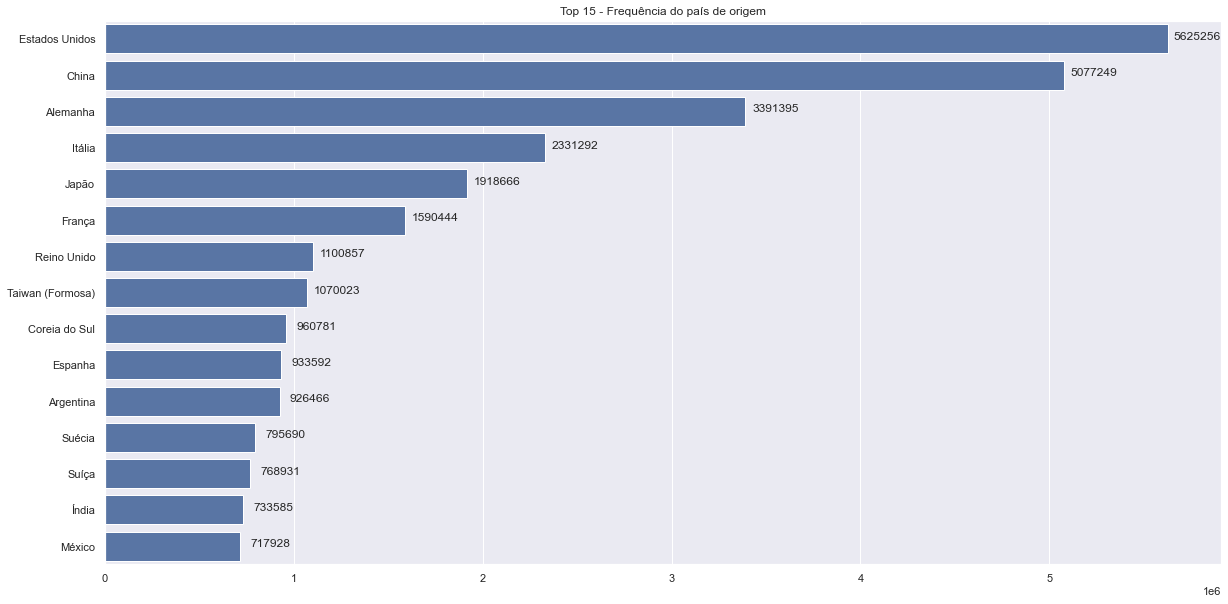

In [9]:
sns.set_theme(style="darkgrid")

# Contagem valores
count = df.NO_PAIS.value_counts()

# Inicializacao figura matplotlib
f, ax = plt.subplots(figsize=(20, 10))
bar = sns.barplot(x=list(count)[:15], y=list(count.index)[:15],
            label="Total", color="b")

for p in bar.patches:
    bar.annotate(int(p.get_width()), 
                   (p.get_width() + p.get_x(), p.get_y()), 
                   ha = 'center', va = 'center', 
                   xytext = (30, -12), 
                   textcoords = 'offset points')
    

ax.set_title("Top 15 - Frequência do país de origem")
plt.show()

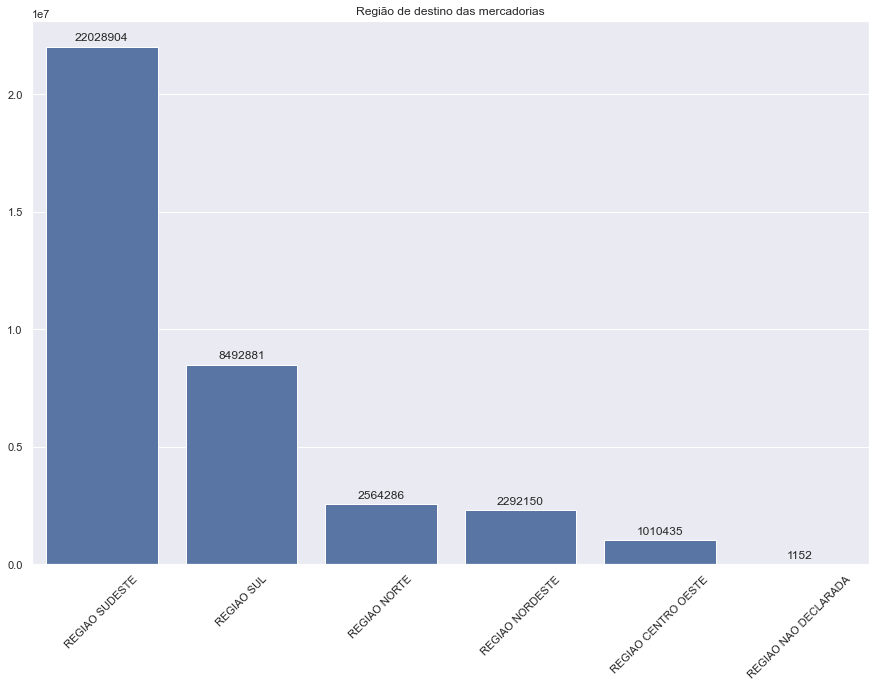

In [11]:
sns.set_theme(style="darkgrid")

# Contagem valores
count = df.NO_REGIAO.value_counts()

# Inicializacao figura matplotlib
f, ax = plt.subplots(figsize=(15, 10))
bar = sns.barplot(y=list(count), x=list(count.index),
            label="Total", color="b")

"""for p in bar.patches:
    bar.annotate(int(p.get_height()), 
                   (p.get_height() + p.get_y(), p.get_y()), 
                   ha = 'center', va = 'center', 
                   xytext = (30, -12), 
                   textcoords = 'offset points')"""
for p in bar.patches:
    bar.annotate(int(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    

ax.set_title("Região de destino das mercadorias")
plt.xticks(rotation=45)
plt.show()

## Produtos
---

Nesse gráfico é mostrado os 10 produtos mais importados desde de 1997 até 2022 e os meios em que os produtos foram importados. A maioria dos produtos são peças ou equipamentos de empresas. Os 10 produtos importados em ordem descrecente:

1. Máquinas e aparelhos elétricos
2. Aparelhos elétricos para ligação, proteção ou conexão de circuitos
3. Instrumentos e aparelhos de medição, verificação, análise e controle
4. Obras de ferro ou aço e outros artigos de metais comuns
5. Válvulas e tubos termiônicas, de cátodo frio ou foto-cátodo, diodos, transistores
6. Pregos, parafusos, porcas, parafusos, rebites e semelhantes, de ferro, aço, cobre ou alumínio
7. Partes e acessórios dos veículos automotivos
8. Equipamentos de telecomunicações, incluindo peças e acessórios
9. Bombas, centrífugas, compressores de ar, ventiladores, exaustores, aparelhos de filtrar ou depurar e suas partes
10. Veios de transmissão e manivelas, engrenagens, rodas de fricção, volantes, polias, embreagens, elos articulados e suas partes

De todos citados acima, predomina os sistemas **Aéreo, Marítimo e o Rodoviário** para transporte.

In [14]:
df.sort_values(by=['NO_CUCI_GRUPO'],inplace=True,ascending=True)

df.reset_index(drop=True,inplace=True)

count = df.NO_CUCI_GRUPO.value_counts()
count = count[:10]
index = count.index

aux = df.copy()
aux.drop_duplicates(subset=['NO_CUCI_GRUPO'],inplace=True,keep='first')

list_df = []
for indx in tqdm(index,total=len(index)):
    posi = aux[aux.NO_CUCI_GRUPO == indx].index[0]
    list_df.append(df.iloc[posi:posi+count[indx]])

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 999.98it/s]


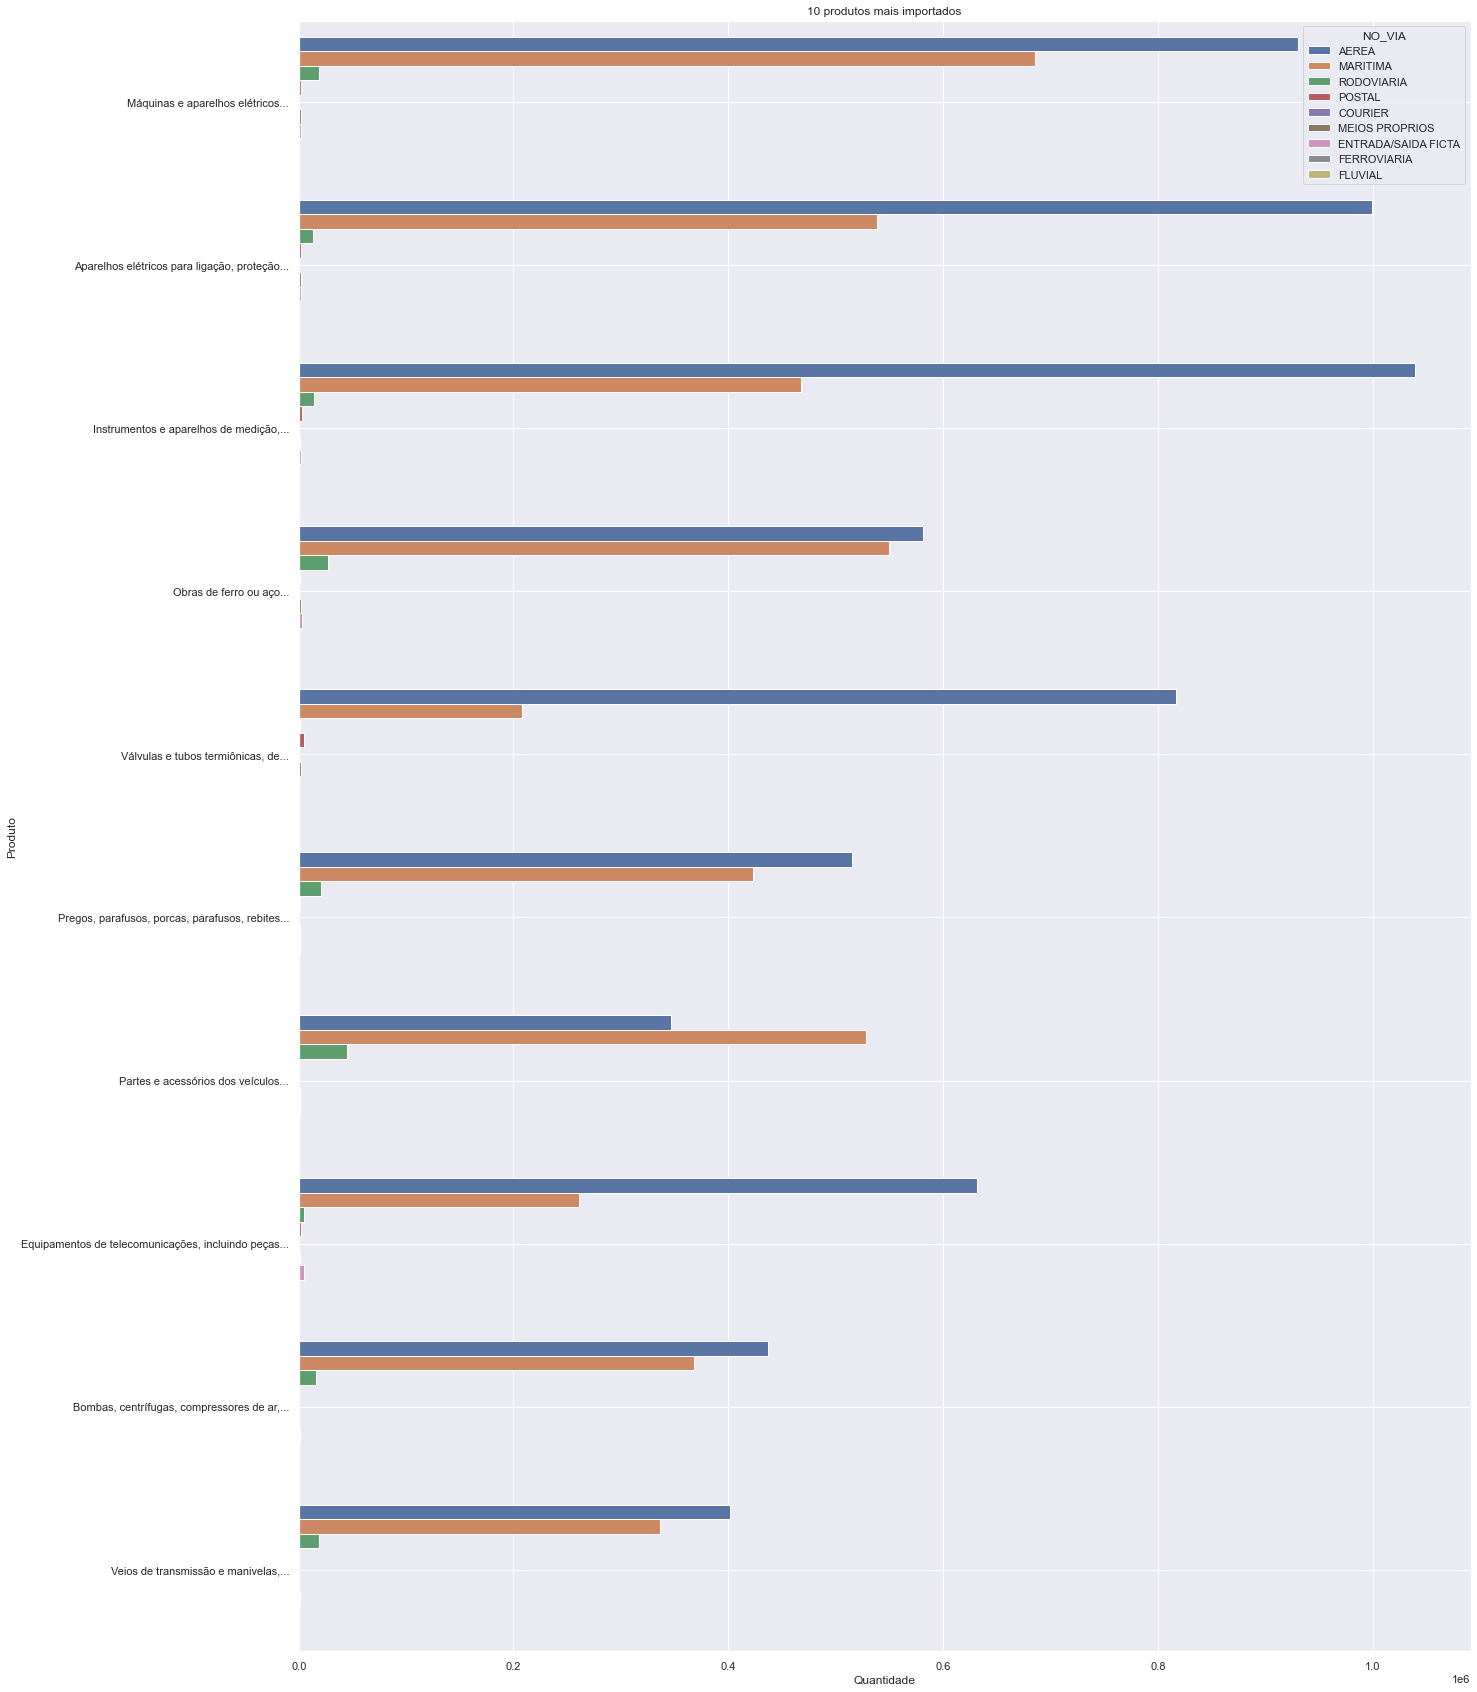

In [16]:
df_aux = pd.concat(list_df)

df_aux.NO_CUCI_GRUPO = df_aux.NO_CUCI_GRUPO.apply(lambda x: " ".join(x.split(" ")[:5]) + "...")

sns.set_theme(style="darkgrid")

# Contagem valores e figura
f, ax = plt.subplots(figsize=(21, 30))
sns.countplot(data=df_aux,y='NO_CUCI_GRUPO',hue='NO_VIA')
ax.grid(True)
ax.set_title('10 produtos mais importados')
ax.set_ylabel('Produto')
ax.set_xlabel('Quantidade')
plt.show()

## Heatmap

In [28]:
corr = df_bruto.corr()

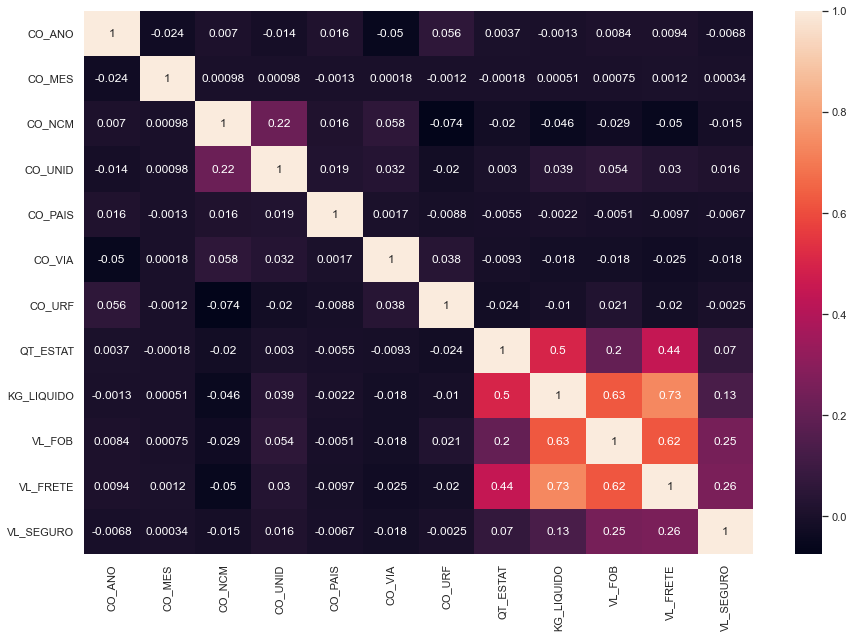

In [29]:
with sns.axes_style("white"):

    f, ax = plt.subplots(figsize=(15, 10))

    ax = sns.heatmap(corr,annot=True)